In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os, re
from poppy.zernike import zernike_basis,decompose_opd

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

ImportError: cannot import name 'zernike_fit' from 'poppy.zernike' (c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\poppy\zernike.py)


<span style="color:green; font-size: 2.5em;">Functions</span>


In [27]:
##########################################################################
##########################################################################
def parse_beam_center(fn):
    bx = by = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Beam Center X [mm]' in L:
                bx = float(L.split(',')[1])
            elif 'Beam Center Y [mm]' in L:
                by = float(L.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by
##########################################################################
##########################################################################
def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan) 
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue 
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)  
        y_coords.append(y)
        wavefront_data.append(vals)
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)
    print(f"x_coords length: {len(x_coords)}")
    print(f"wavefront_data shape: {wf_array.shape}")
    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")
    return x_coords, y_coords, wf_array
##########################################################################
##########################################################################
def parse_zernike_coeffs(fn, n_modes):
    coeffs = []
    in_z = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if L.strip().startswith('*** ZERNIKE FIT ***'):
                in_z = True
                continue
            if in_z:
                m = pat.match(L)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    return np.array(coeffs)
##########################################################################
##########################################################################
def noll_to_zernike(j):
    n = 0; j1 = j - 1
    while j1 >= n+1:
        n += 1; j1 -= n
    m = -n + 2*j1
    return n, m
##########################################################################
##########################################################################
def remap_sensor_coeffs(raw, n_modes):
    rem = np.zeros(n_modes)
    for i, c in enumerate(raw, start=1):
        tgt = {2:3, 3:2}.get(i, i)
        if tgt <= n_modes:
            rem[tgt-1] = c
    return rem
##########################################################################
##########################################################################

##########################################################################
##########################################################################   
def parse_pupil_diameter(fn):
    pd = None
    pcx = None
    pcy = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Pupil Diameter X [mm]' in L:
                pd = float(L.split(',')[1])
            elif 'Pupil Center X [mm]' in L:
                pcx = float(L.split(',')[1])
            elif 'Pupil Center Y [mm]' in L:
                pcy = float(L.split(',')[1])
    if pd is None or pcx is None or pcy is None:
        raise RuntimeError("Pupil diameter or center not found")
    return pd, pcx, pcy
##########################################################################
##########################################################################





<span style="color:blue; font-size: 2.5em;">Grafici </span>

In [37]:
def plot_wavefront(x_coords, y_coords, wf_array, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(wf_array, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
                   origin='upper', cmap='jet', aspect='auto')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    if title:
        ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Wavefront Error [nm]')
    plt.show()

<span style="color:yellow; font-size: 2.5em;">Variabili in input </span>

In [23]:


file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus"
filenumber = 9 # sceglie il file specifico nella cartella directory
pupil_diameter = 5.8  # mm
nterms        = 15



<span style="color:orange; font-size: 2.5em;">Codice </span>

x_coords length: 74
wavefront_data shape: (45, 74)


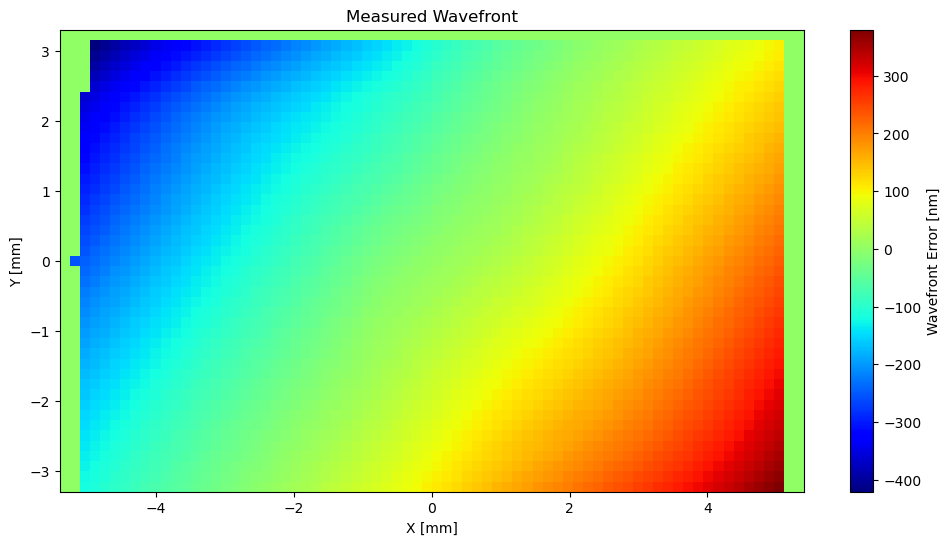

In [ ]:

from sklearn.metrics import mean_squared_error

files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError("No CSV files found in directory")
filename = files[filenumber]
full_path = os.path.join(directory, filename)
file = full_path  

x, y, wavefront = parse_wavefront_grid(file)
# Filter out NaN values
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
wavefront = np.nan_to_num(wavefront, nan=0.0)


# 1. Parse pupil diameter and center
pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter(file)

# 2. Convert pupil diameter and center from mm to pixels
pixel_scale = x[1] - x[0]  # Assuming uniform grid
pupil_radius_pix = (pupil_diameter / 2) / pixel_scale
x_center_pix = (pupil_center_x - x[0]) / pixel_scale
y_center_pix = (pupil_center_y - y[0]) / pixel_scale
x_center_pix = int(x_center_pix)
y_center_pix = int(y_center_pix)
print(f"Pupil radius in pixels: {pupil_radius_pix}")
print(f"Pupil center in pixels: ({x_center_pix}, {y_center_pix})")

# 3. Apply circular mask to the wavefront data
wf_masked = np.copy(wavefront)


# 4. Create mask based on actual center/radius
yy, xx = np.indices(wavefront.shape)
r = np.sqrt((xx - x_center_pix)**2 + (yy - y_center_pix)**2)
mask = r <= pupil_radius_pix





plot_wavefront(x, y, wavefront, title='Measured Wavefront')

